# Modelagem

## Loading Data and Libraries

In [1]:
import unidecode
import os
import sys

sys.path.append('../src/')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

%matplotlib inline
%load_ext autoreload
%autoreload 2

DATAPATH = '../data/'

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from bayes_opt import BayesianOptimization

In [2]:
dataset = pd.read_csv('../data/raw/preprocessed/dataset.csv')
print(dataset.shape)
dataset.head(5)

(37646, 45)


,uf_res_dif_paciente,mun_res_dif_paciente,cod_idade,num_idade,sexo,trat_anter,car_atend,rf_tomografos_computadorizados,rf_mamografos,rfressonancia_magnetica,equipes_de_saude_equipes_saude_da_familia,rh_medicos,equipes_de_saude_nucleos_de_apoio_a_saude_da_familia_nasf,rf_leitos_de_internacao,rh_enfermeiros,rf_raios_x,CAPITAL,IDHM,IDHM_Longevidade,IDHM_Educacao,AREA,ESTIMATED_POP,GVA_SERVICES,GDP,POP_GDP,GDP_CAPITA,COMP_Q,distancia_paciente_estab,tardio,tempo_atend_identificacao,tempo_autorizar,qtd_estab_uf,qtd_estab_mun,Intermediário Adjacente,Intermediário Remoto,Rural Adjacente,Rural Remoto,Sem classificação,Urbano,raca_cor_1,raca_cor_2,raca_cor_3,raca_cor_4,raca_cor_5,raca_cor_99
0,0.0,1.0,4.0,71.0,0,1,1.0,4.0,4.0,2.0,4.0,179.0,1.0,188.0,93.0,27.0,0,0.782,0.845,0.728,539087.00,81893.0,1651459.19,3331621.74,79869.0,41713.58,222.0,442.430550,1,-1,4.0,62,2.0,0,0,0,0,0,1,0,0,1,0,0,0
1,0.0,1.0,4.0,70.0,1,0,1.0,1.0,3.0,1.0,6.0,235.0,1.0,184.0,141.0,11.0,0,0.780,0.858,0.707,689.09,83173.0,1650768.35,3048217.08,83089.0,36686.17,124.0,0.306397,1,0,0.0,70,1.0,0,0,0,0,0,1,0,0,1,0,0,0
2,0.0,1.0,4.0,81.0,0,0,1.0,2.0,3.0,1.0,0.0,112.0,0.0,94.0,56.0,7.0,0,0.770,0.840,0.707,665515.00,61949.0,1571.42,2645.23,62193.0,42532.60,71.0,0.641971,1,0,0.0,70,1.0,0,0,0,0,0,1,1,0,0,0,0,0
3,0.0,1.0,4.0,30.0,0,0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,28.0,7.0,1.0,0,0.597,0.737,0.512,63279.00,4095.0,7929.41,30269.10,4204.0,7200.07,2.0,120.395750,1,0,1.0,10,0.0,0,0,1,0,0,0,0,0,0,0,0,1
4,0.0,1.0,4.0,3.0,1,0,1.0,12.0,11.0,5.0,22.0,2121.0,3.0,2076.0,810.0,81.0,1,0.763,0.835,0.694,167401.00,877640.0,12122912.17,21845480.68,877662.0,24890.54,1165.0,9.062047,1,0,0.0,10,5.0,0,0,0,0,0,1,0,0,0,0,0,1


## Separação dos conjuntos de treino e teste

In [35]:
X = dataset.drop('tardio', axis=1)
y = dataset['tardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Teste inicial com diferentes algoritmos

In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import lightgbm as lgb
import xgboost as xgb

In [5]:
classifiers = [('RF', RandomForestClassifier()), ('GB', GradientBoostingClassifier()), ('AB', AdaBoostClassifier()),
              ('LB', lgb.LGBMClassifier()), ('XB', xgb.XGBClassifier())]

In [6]:
for clf in classifiers:
    print(clf[0])
    
    scores = cross_val_score(estimator=clf[1], X=X_train, y=y_train, scoring='roc_auc', cv=5, n_jobs=-1)
    print('%.3f (%.3f)' % (scores.mean(), scores.std()))
    
    print('\n')

RF
0.669 (0.008)


GB
0.683 (0.005)


AB
0.637 (0.006)


LB
0.717 (0.003)


XB
0.683 (0.002)




## Otimização dos hiperparâmetros
De maneira breve, utilizando os parâmetros padrões das respectivas libs, foram testados alguns modelos que são baseados em ensemble de árvores. Depois de realizar uma validação cruzada, o modelo com melhor resultado (LightGBM) será selecionado e terá seus parâmetros otimizados com a técnica de Otimização Bayesiana.

In [7]:
n_folds = 5

In [8]:
train_set = lgb.Dataset(X_train, y_train)

In [9]:
# Parâmetros com intervalos que serão otimizados 
parameters = {
    'num_leaves': (7, 100),
    'max_depth': (3, 32),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1),
    'min_child_samples': (12, 300),
}

In [10]:
# Parâmetro para balanceamento
scale_pos_weight  = y_train[y_train==0].count() / y_train[y_train==1].count()

In [11]:
def lgb_optimization(num_leaves, max_depth, subsample, colsample_bytree, min_child_samples):
    params = {
        'objective': 'binary',
        'num_leaves': int(num_leaves),
        'max_depth': int(max_depth),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_samples': int(min_child_samples),
        'scale_pos_weight': scale_pos_weight,
        'n_jobs': -1
    }
    
    cv_results = lgb.cv(params, train_set, nfold=n_folds, stratified=False, shuffle=True, num_boost_round = 4000, 
                        early_stopping_rounds=50, metrics='auc', seed = 50)
    
    return np.max(cv_results['auc-mean'])

In [12]:
BO = BayesianOptimization(lgb_optimization, parameters, verbose=10)
BO.maximize(init_points=2, n_iter=300, acq='ei')

|   iter    |  target   | colsam... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.7166   |  0.9358   |  10.95    |  33.15    |  47.47    |  0.5515   |
|  2        |  0.7164   |  0.5636   |  18.87    |  72.71    |  21.35    |  0.6343   |
|  3        |  0.7153   |  0.8843   |  31.74    |  300.0    |  98.33    |  0.6309   |
|  4        |  0.7162   |  0.5522   |  30.9     |  13.06    |  99.95    |  0.5838   |
|  5        |  0.7084   |  0.6527   |  3.752    |  13.18    |  8.153    |  0.7825   |
|  6        |  0.7084   |  0.9028   |  3.06     |  146.8    |  98.02    |  0.9649   |
|  7        |  0.7109   |  0.5668   |  31.73    |  298.5    |  7.444    |  0.729    |
|  8        |  0.7185   |  0.7247   |  31.96    |  68.0     |  56.44    |  0.5095   |
|  9        |  0.7193   |  0.9515   |  31.8     |  50.38    |  50.06    |  0.7013   |
|  10       |  0.7066   |  0.5358   |  3.532    |  299

C:\Users\Milton\Anaconda3\lib\site-packages\bayes_opt\util.py:117: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std


|  196      |  0.717    |  0.9846   |  31.98    |  166.2    |  59.22    |  0.9373   |
|  197      |  0.7181   |  0.9807   |  31.93    |  46.57    |  65.95    |  0.9627   |
|  198      |  0.7185   |  0.9377   |  31.93    |  14.67    |  99.66    |  0.5108   |
|  199      |  0.7169   |  0.9757   |  31.92    |  191.3    |  99.92    |  0.5014   |
|  200      |  0.7143   |  0.9638   |  31.64    |  298.9    |  97.68    |  0.8666   |
|  201      |  0.7173   |  0.5119   |  31.98    |  79.89    |  97.81    |  0.8873   |
|  202      |  0.7191   |  0.9843   |  31.83    |  104.0    |  61.26    |  0.9976   |
|  203      |  0.7186   |  0.9741   |  31.85    |  37.01    |  98.24    |  0.9957   |
|  204      |  0.7176   |  0.996    |  31.94    |  117.5    |  71.3     |  0.9646   |
|  205      |  0.7185   |  0.9961   |  31.62    |  75.5     |  98.07    |  0.9629   |
|  206      |  0.7181   |  0.5334   |  31.84    |  72.43    |  72.31    |  0.5297   |
|  207      |  0.7181   |  0.9191   |  31.97    |  192

C:\Users\Milton\Anaconda3\lib\site-packages\bayes_opt\util.py:117: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std


|  251      |  0.7153   |  0.958    |  31.86    |  299.9    |  51.04    |  0.85     |
|  252      |  0.7191   |  0.9959   |  31.8     |  12.08    |  60.38    |  0.7415   |
|  253      |  0.7209   |  0.9562   |  31.8     |  48.5     |  50.16    |  0.9355   |


C:\Users\Milton\Anaconda3\lib\site-packages\bayes_opt\util.py:117: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std


|  254      |  0.718    |  0.9836   |  31.42    |  114.6    |  96.95    |  0.9981   |
|  255      |  0.7179   |  0.9975   |  31.08    |  38.71    |  74.98    |  0.9207   |
|  256      |  0.7189   |  0.981    |  31.89    |  59.12    |  55.3     |  0.8708   |
|  257      |  0.7181   |  0.9994   |  31.78    |  55.26    |  35.92    |  0.8972   |
|  258      |  0.7162   |  0.9989   |  31.74    |  70.24    |  26.28    |  0.98     |
|  259      |  0.7182   |  0.9888   |  31.97    |  25.45    |  98.96    |  0.8288   |
|  260      |  0.7177   |  0.9631   |  31.37    |  96.95    |  98.81    |  0.9498   |


C:\Users\Milton\Anaconda3\lib\site-packages\bayes_opt\util.py:117: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std


|  261      |  0.7173   |  0.9746   |  31.98    |  134.5    |  63.06    |  0.8788   |
|  262      |  0.7179   |  0.9844   |  31.46    |  34.43    |  45.05    |  0.9705   |


C:\Users\Milton\Anaconda3\lib\site-packages\bayes_opt\util.py:117: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std


|  263      |  0.7152   |  0.8956   |  31.89    |  239.6    |  99.27    |  0.9715   |
|  264      |  0.7185   |  0.9989   |  31.84    |  30.96    |  73.11    |  0.5614   |
|  265      |  0.7189   |  0.9524   |  31.41    |  12.71    |  99.51    |  0.5564   |
|  266      |  0.7186   |  0.544    |  31.77    |  16.07    |  98.21    |  0.9559   |
|  267      |  0.7189   |  0.9779   |  31.68    |  53.02    |  72.68    |  0.9346   |
|  268      |  0.7204   |  0.9707   |  31.98    |  32.57    |  99.59    |  0.9036   |
|  269      |  0.7183   |  0.9876   |  31.77    |  143.2    |  57.52    |  0.8143   |
|  270      |  0.7189   |  0.9793   |  31.9     |  41.28    |  85.97    |  0.5183   |
|  271      |  0.7178   |  0.9904   |  31.5     |  51.79    |  49.22    |  0.5137   |
|  272      |  0.7148   |  0.9747   |  31.57    |  299.0    |  99.87    |  0.888    |
|  273      |  0.7178   |  0.9841   |  31.6     |  59.73    |  69.19    |  0.986    |
|  274      |  0.7194   |  0.9787   |  31.79    |  58.

C:\Users\Milton\Anaconda3\lib\site-packages\bayes_opt\util.py:117: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std


|  283      |  0.7107   |  0.9699   |  31.37    |  299.2    |  7.657    |  0.63     |
|  284      |  0.7194   |  0.9668   |  31.99    |  31.59    |  98.79    |  0.9616   |
|  285      |  0.7188   |  0.9961   |  31.99    |  89.57    |  51.64    |  0.5831   |
|  286      |  0.7189   |  0.9536   |  31.98    |  133.8    |  63.02    |  0.5671   |
|  287      |  0.7183   |  0.9408   |  31.9     |  65.86    |  95.47    |  0.5399   |


C:\Users\Milton\Anaconda3\lib\site-packages\bayes_opt\util.py:117: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std


|  288      |  0.717    |  0.9631   |  31.53    |  116.9    |  38.09    |  0.9263   |
|  289      |  0.717    |  0.508    |  31.58    |  150.2    |  68.39    |  0.5154   |
|  290      |  0.7183   |  0.5976   |  31.99    |  41.1     |  99.31    |  0.6745   |
|  291      |  0.7173   |  0.9893   |  31.75    |  185.4    |  53.39    |  0.5495   |


C:\Users\Milton\Anaconda3\lib\site-packages\bayes_opt\util.py:117: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std


|  292      |  0.7121   |  0.9676   |  31.86    |  86.97    |  7.277    |  0.8732   |
|  293      |  0.7186   |  0.9863   |  31.59    |  51.05    |  78.71    |  0.9788   |
|  294      |  0.7184   |  0.9859   |  31.79    |  33.14    |  84.51    |  0.7668   |
|  295      |  0.7175   |  0.9891   |  31.99    |  125.1    |  69.07    |  0.9329   |


C:\Users\Milton\Anaconda3\lib\site-packages\bayes_opt\util.py:117: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std
C:\Users\Milton\Anaconda3\lib\site-packages\bayes_opt\util.py:117: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std


|  296      |  0.7105   |  0.9987   |  4.228    |  217.0    |  64.24    |  0.5073   |


C:\Users\Milton\Anaconda3\lib\site-packages\bayes_opt\util.py:117: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std


|  297      |  0.7169   |  0.9805   |  31.83    |  152.3    |  38.44    |  0.9209   |
|  298      |  0.7181   |  0.9746   |  31.74    |  51.55    |  76.03    |  0.9487   |
|  299      |  0.7187   |  0.988    |  31.94    |  120.6    |  91.9     |  0.54     |
|  300      |  0.7182   |  0.9447   |  31.81    |  12.82    |  81.99    |  0.545    |
|  301      |  0.7187   |  0.5919   |  31.98    |  80.99    |  71.43    |  0.5191   |
|  302      |  0.7192   |  0.9456   |  31.6     |  33.86    |  88.27    |  0.9809   |


In [13]:
BO.max

{'target': 0.7208895247967847,
 'params': {'colsample_bytree': 0.9562040219097038,
  'max_depth': 31.797316264508694,
  'min_child_samples': 48.49680214226089,
  'num_leaves': 50.15919162591018,
  'subsample': 0.9355391915436526}}

### Carregar modelo com os melhores parâmetros

In [100]:
best_params = BO.max['params']
colsample_bytree = best_params['colsample_bytree']
subsample = best_params['subsample']
max_depth = int(best_params['max_depth'])
num_leaves = int(best_params['num_leaves'])
scale_pos_weight = scale_pos_weight
model = lgb.LGBMClassifier(colsample_bytree=colsample_bytree, subsample=subsample, 
                           max_depth=max_depth, num_leaves=num_leaves, scale_pos_weight=scale_pos_weight)

In [101]:
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.9562040219097038, importance_type='split',
        learning_rate=0.1, max_depth=31, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=1.2282377081524742,
        silent=True, subsample=0.9355391915436526,
        subsample_for_bin=200000, subsample_freq=0)

In [102]:
pred = model.predict(X_test)

print('Acurácia:', accuracy_score(y_test, pred))
print('AUC ROC:', roc_auc_score(y_test, pred))

Acurácia: 0.662558436039099
AUC ROC: 0.661861707103714


In [103]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [104]:
eval_set = [(X_val, y_val)]

In [105]:
model.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=50, eval_metric='auc', verbose=False)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.9562040219097038, importance_type='split',
        learning_rate=0.1, max_depth=31, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=50, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=1.2282377081524742,
        silent=True, subsample=0.9355391915436526,
        subsample_for_bin=200000, subsample_freq=0)

In [106]:
pred = model.predict(X_test)

print('Acurácia:', accuracy_score(y_test, pred))
print('AUC ROC:', roc_auc_score(y_test, pred))

Acurácia: 0.66755206119847
AUC ROC: 0.6666623356563961


In [109]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.71      0.68      0.69      5166
           1       0.63      0.66      0.64      4246

   micro avg       0.67      0.67      0.67      9412
   macro avg       0.67      0.67      0.67      9412
weighted avg       0.67      0.67      0.67      9412



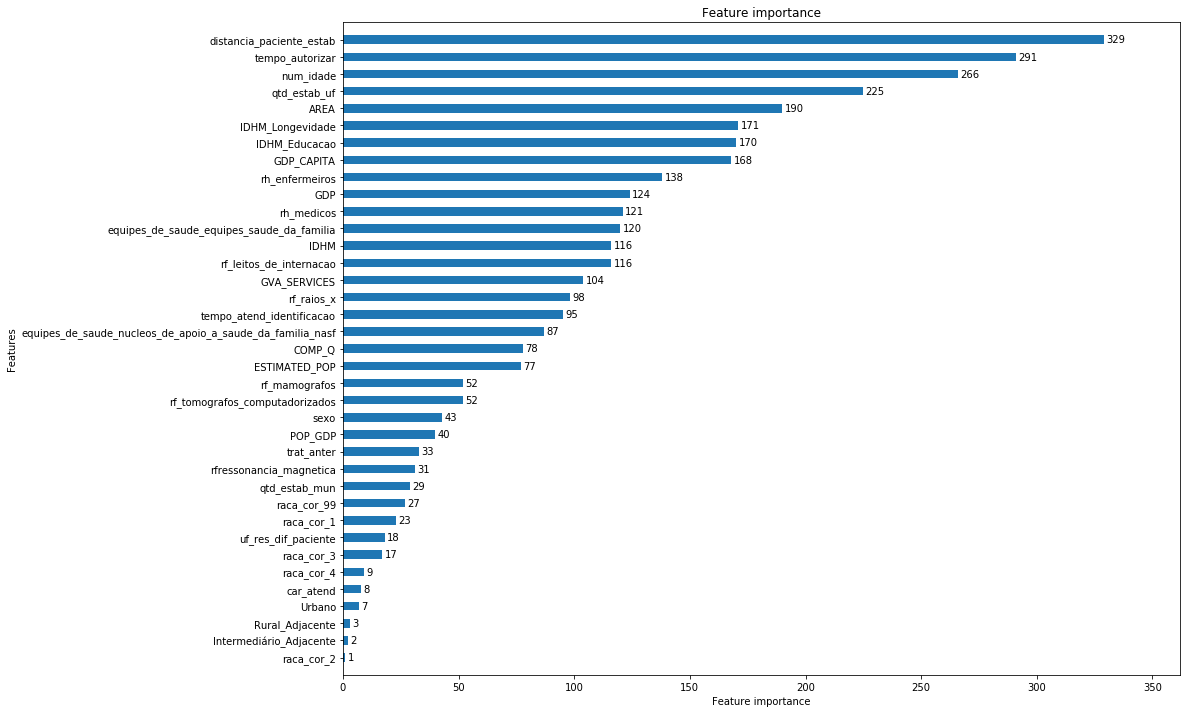

In [107]:
fig, ax = plt.subplots(figsize=(15,12))
lgb.plot_importance(model, height=0.5, ax=ax, grid=False)
plt.savefig('feature_importance_lgbm.png')